In [ ]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from types import SimpleNamespace

# Silence TensorFlow, XLA, cuDNN, and Abseil noise
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["ABSL_LOGGING_LEVEL"] = "fatal"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ["XLA_FLAGS"] = "--xla_gpu_enable_triton_gemm=false"

import silence_tensorflow.auto

import tensorflow as tf
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
tf.get_logger().setLevel("ERROR")
tf.config.optimizer.set_jit(False)

import keras_hub

2025-10-18 14:42:49.598420: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-18 14:42:49.610145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760791369.622328 3882432 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760791369.626290 3882432 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760791369.637044 3882432 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
args = SimpleNamespace(
    data_dir="data/artbench-10",
    img_size=(224, 224),
    batch_size=128,
    val_split=0.2,
    seed=42,
    epochs=200,
    lr_warmup=5e-4,
    lr_finetune=3e-5,
    preset="resnet_vd_200_imagenet",
    results_dir="results",
    warmup_epochs=5,
)

In [3]:
slurm_id = os.environ.get("SLURM_JOB_ID", "")
tag = f"_{slurm_id}" if slurm_id else ""

os.makedirs(args.results_dir, exist_ok=True)

# Seeds
tf.keras.utils.set_random_seed(args.seed)
random.seed(args.seed)
np.random.seed(args.seed)

In [4]:
def plot_history(history):
    hist = history.history
    xx = np.arange(1, len(hist["loss"]) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    plt.subplots_adjust(wspace=0.3)

    ax = axs[0]; ax.grid(True); ax.set_ylabel("loss")
    ax.plot(xx, hist["loss"], "b-", label="loss")
    ax.plot(xx, hist["val_loss"], "r-", label="val_loss")
    ax.legend(loc="best")

    ax = axs[1]; ax.grid(True); ax.set_ylabel("accuracy")
    ax.plot(xx, hist["accuracy"], "b-", label="accuracy")
    ax.plot(xx, hist["val_accuracy"], "r-", label="val_accuracy")
    ax.legend(loc="best")

    for ax in axs:
        ax.set_xlabel("epoch")

    plt.show()

def plot_confusion_matrix(cm, classes, normalize=True):
    if normalize:
        cm = cm.astype("float") / (cm.sum(axis=1, keepdims=True) + 1e-12)

    plt.figure(figsize=(5.5, 4.5))
    plt.imshow(cm, interpolation="nearest", cmap="viridis")
    plt.title("Confusion matrix" + (" (normalized)" if normalize else ""))
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = format(cm[i, j], fmt)
            plt.text(j, i, val,
                     ha="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=7)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

def merge_histories(H_list):
    merged = {}
    for H in H_list:
        for k, v in H.history.items():
            merged.setdefault(k, [])
            merged[k].extend(v)
    class _Hist:
        def __init__(self, hist):
            self.history = hist
    return _Hist(merged)

In [5]:
def build_datasets(data_dir, img_size, batch_size, val_split, seed):
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(data_dir, "train"),
        validation_split=val_split,
        subset="training",
        seed=seed,
        image_size=tuple(img_size),
        batch_size=batch_size,
        label_mode="int",
        shuffle=True,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(data_dir, "train"),
        validation_split=val_split,
        subset="validation",
        seed=seed,
        image_size=tuple(img_size),
        batch_size=batch_size,
        label_mode="int",
        shuffle=False,
    )

    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(data_dir, "test"),
        image_size=tuple(img_size),
        batch_size=batch_size,
        label_mode="int",
        shuffle=False,
    )

    class_names = train_ds.class_names
    num_classes = len(class_names)

    train_ds = train_ds.prefetch(AUTOTUNE)
    val_ds   = val_ds.prefetch(AUTOTUNE)
    test_ds  = test_ds.prefetch(AUTOTUNE)

    return train_ds, val_ds, test_ds, class_names, num_classes

train_ds, val_ds, test_ds, class_names, num_classes = build_datasets(
    args.data_dir, args.img_size, args.batch_size, args.val_split, args.seed
)
print(f"Classes ({num_classes}):", class_names)

Found 50000 files belonging to 10 classes.


Using 40000 files for training.


2025-10-18 14:42:55.230840: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1760791375.231811 3882432 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43500 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:41:00.0, compute capability: 8.9


Found 50000 files belonging to 10 classes.


Using 10000 files for validation.


Found 10000 files belonging to 10 classes.


Classes (10): ['art_nouveau', 'baroque', 'expressionism', 'impressionism', 'post_impressionism', 'realism', 'renaissance', 'romanticism', 'surrealism', 'ukiyo_e']


In [6]:
M = keras_hub.models.ImageClassifier.from_preset(
    args.preset,
    num_classes=num_classes,
    activation="softmax",
    dropout=0.5,
)

In [7]:
acc_metric = tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")
top5_metric = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5")

reduce_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy", factor=0.4, patience=6, verbose=0
)
early_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=12, restore_best_weights=True, verbose=0
)

In [8]:
warmup_epochs = max(1, min(args.warmup_epochs, args.epochs))
print(f"Warmup epochs (frozen backbone): {warmup_epochs}")

M.backbone.trainable = False
optimizer_warmup = tf.keras.optimizers.Adam(learning_rate=args.lr_warmup)
M.compile(
    optimizer=optimizer_warmup,
    loss="sparse_categorical_crossentropy",
    metrics=[acc_metric, top5_metric],
)
H1 = M.fit(
    train_ds,
    validation_data=val_ds,
    epochs=warmup_epochs,
    verbose=0
)

Warmup epochs (frozen backbone): 5


I0000 00:00:1760791390.615708 3883408 service.cc:152] XLA service 0x767408002ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760791390.615899 3883408 service.cc:160]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9


2025-10-18 14:43:11.627463: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


I0000 00:00:1760791395.071770 3883408 cuda_dnn.cc:529] Loaded cuDNN version 91400


I0000 00:00:1760791401.417775 3883408 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2025-10-18 14:44:20.081384: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4278', 60 bytes spill stores, 60 bytes spill loads

2025-10-18 14:44:20.243889: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4278', 3620 bytes spill stores, 3612 bytes spill loads

2025-10-18 14:44:20.251188: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4278', 3872 bytes spill stores, 3848 bytes spill loads



2025-10-18 14:44:35.072987: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4278', 3620 bytes spill stores, 3612 bytes spill loads



In [9]:
print(f"Fine-tune epochs (unfrozen backbone): {args.epochs - warmup_epochs}")
M.backbone.trainable = True
optimizer = tf.keras.optimizers.Adam(learning_rate=args.lr_finetune)
M.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=[acc_metric, top5_metric],
)
H2 = M.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=warmup_epochs,
    epochs=args.epochs,
    callbacks=[reduce_cb, early_cb],
    verbose=0
)

Fine-tune epochs (unfrozen backbone): 195


2025-10-18 14:49:34.853686: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


In [10]:
H = merge_histories([H1, H2])
train_metrics = M.evaluate(train_ds, return_dict=True, verbose=0)
test_metrics  = M.evaluate(test_ds,  return_dict=True, verbose=0)

acc_train = float(train_metrics["accuracy"])
acc_test  = float(test_metrics["accuracy"])
top5_test = test_metrics.get("top5")

print(f"Train accuracy : {acc_train:.2%}")
print(f"Test accuracy  : {acc_test:.2%}")
print(f"Test top-5     : {top5_test:.2%}")

2025-10-18 16:32:31.465284: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4278', 60 bytes spill stores, 60 bytes spill loads



2025-10-18 16:32:31.689464: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4278', 3620 bytes spill stores, 3612 bytes spill loads

2025-10-18 16:32:31.805368: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4278', 3872 bytes spill stores, 3848 bytes spill loads



Train accuracy : 100.00%
Test accuracy  : 67.25%
Test top-5     : 96.99%


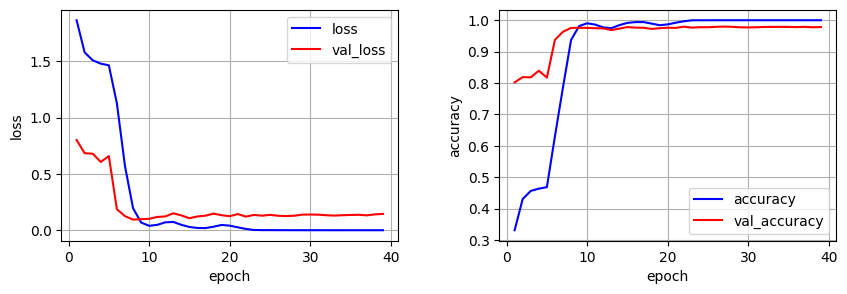

In [11]:
plot_history(H)

2025-10-18 16:32:44.511551: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


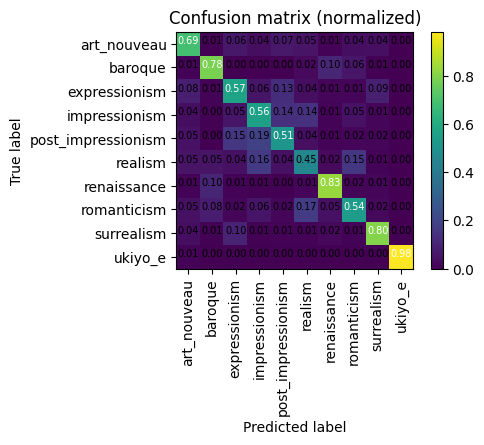

In [12]:
# True labels
y_true = []
for _, y in test_ds:
    y_true.append(y.numpy())
y_true = np.concatenate(y_true, axis=0)

# Predictions
y_pred = np.argmax(M.predict(test_ds, verbose=0), axis=1)

# Confusion matrix plot
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
plot_confusion_matrix(cm, class_names, normalize=True)

In [13]:
report = classification_report(
    y_true, y_pred, target_names=class_names, digits=3
)
print(report)

                    precision    recall  f1-score   support

       art_nouveau      0.678     0.690     0.684      1000
           baroque      0.752     0.785     0.768      1000
     expressionism      0.563     0.569     0.566      1000
     impressionism      0.516     0.559     0.536      1000
post_impressionism      0.559     0.515     0.536      1000
           realism      0.478     0.453     0.465      1000
       renaissance      0.774     0.829     0.801      1000
       romanticism      0.607     0.543     0.573      1000
        surrealism      0.792     0.800     0.796      1000
           ukiyo_e      0.982     0.982     0.982      1000

          accuracy                          0.672     10000
         macro avg      0.670     0.672     0.671     10000
      weighted avg      0.670     0.672     0.671     10000

